In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm #progress bar library -- not necessary, but helpful since some of this is slower

In [39]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
%matplotlib inline
sns.set()

In [71]:
df = pd.read_pickle('raw_data.pkl')

In [72]:
df = df[df.season == '2020-21']

In [97]:
df.head()

,name,position,team,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,round,team_a_score,team_h_score,total_points,value,was_home,gw,season,pp90,prev_5_pp90,prev_5_std,prev_5_max,prev_5_ict,fwd_5_pp90
66817,Aaron Connolly,4.0,Brighton,0,0,-3,0,0.3,78,7,2,0,3.4,1.2,2020-09-14T19:15:00Z,45,5,1,3.0,1.0,1,55,True,1,2020-21,2.000000,NaN,NaN,NaN,NaN,9.064974
67242,Aaron Connolly,4.0,Brighton,0,2,27,1,11.3,78,16,0,1,6.9,34.8,2020-09-20T13:00:00Z,89,14,2,3.0,0.0,8,55,False,2,2020-21,8.089888,NaN,NaN,NaN,NaN,13.164974
67781,Aaron Connolly,4.0,Brighton,0,0,2,0,12.1,78,19,2,0,1.9,0.0,2020-09-26T11:30:00Z,73,13,3,3.0,2.0,2,55,True,3,2020-21,2.465753,NaN,NaN,NaN,NaN,12.127642
68335,Aaron Connolly,4.0,Brighton,0,0,7,0,0.3,78,32,3,0,0.7,3.0,2020-10-03T14:00:00Z,65,7,4,2.0,4.0,2,55,False,4,2020-21,2.769231,NaN,NaN,NaN,NaN,12.205920
71872,Aaron Connolly,4.0,Brighton,0,0,0,0,12.0,78,90,1,0,4.0,0.0,2020-11-28T12:30:00Z,62,11,10,1.0,1.0,2,53,True,10,2020-21,2.903226,12.127642,13.16272,30.0,1.9,4.194931


In [106]:
df = df[df.position > 1] #going to focus on analysis of field players, don't want correlations of goalkeepers to throw off findings

In [114]:
df.groupby('name').mean().corr()['total_points'].sort_values(ascending=False)

total_points      1.000000
pp90              0.954026
fwd_4_pp90        0.934789
prev_5_pp90       0.933950
prev_5_max        0.848366
bonus             0.810895
prev_5_std        0.774186
prev_5_ict        0.756866
ict_index         0.736952
bps               0.729268
goals_scored      0.726239
influence         0.689734
prev_5_bps        0.649060
clean_sheets      0.617779
prev_5_assists    0.586852
assists           0.580023
value             0.561197
creativity        0.464254
minutes           0.351716
fixture           0.223809
round             0.211888
gw                0.211888
position          0.136717
opponent_team     0.062519
was_home          0.027147
fwd_5_pp90       -0.064316
team_a_score     -0.069480
team_h_score     -0.089881
element          -0.118582
goals_conceded   -0.398569
Name: total_points, dtype: float64

In [74]:
df['pp90'] = (df['total_points']/df['minutes']) * 90

In [75]:
df = df[df['minutes'] > 0]
df.head()

,name,position,team,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,round,team_a_score,team_h_score,total_points,value,was_home,gw,season,pp90
66817,Aaron Connolly,4.0,Brighton,0,0,-3,0,0.3,78,7,2,0,3.4,1.2,2020-09-14T19:15:00Z,45,5,1,3.0,1.0,1,55,True,1,2020-21,2.000000
66818,Aaron Cresswell,2.0,West Ham,0,0,11,0,11.2,435,6,2,0,2.2,10.4,2020-09-12T19:00:00Z,90,14,1,2.0,0.0,1,50,True,1,2020-21,1.000000
66820,Aaron Ramsdale,1.0,Sheffield Utd,0,0,12,0,0.0,483,8,2,0,1.8,18.2,2020-09-14T17:00:00Z,90,20,1,2.0,0.0,1,50,True,1,2020-21,1.000000
66821,Abdoulaye DoucourÃ©,3.0,Everton,0,0,20,1,44.6,512,4,0,0,6.9,20.4,2020-09-13T15:30:00Z,90,17,1,1.0,0.0,3,55,False,1,2020-21,3.000000
66822,Aboubakar Kamara,3.0,Fulham,0,0,-2,0,1.8,190,2,3,0,0.2,0.0,2020-09-12T11:30:00Z,62,1,1,3.0,0.0,2,50,True,1,2020-21,2.903226


In [109]:
prev_5_pp90 = []
prev_5_std = []
prev_5_max = []
prev_5_ict = []
prev_5_assists = []
prev_5_bps = []
fwd_4_pp90 = []

indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=4)

df = df.sort_values(['name', 'kickoff_time'])

for player in df.name.unique():
    prev_5_pp90.extend(df[df['name'] == player].rolling(5)['pp90'].mean())
    prev_5_std.extend(df[df['name'] == player].rolling(5)['pp90'].std())
    prev_5_max.extend(df[df['name'] == player].rolling(5)['pp90'].max())
    prev_5_ict.extend(df[df['name'] == player].rolling(5)['ict_index'].mean())
    prev_5_assists.extend(df[df['name'] == player].rolling(5)['assists'].mean())
    prev_5_bps.extend(df[df['name'] == player].rolling(5)['bps'].mean())
    fwd_4_pp90.extend(df[df['name'] == player].rolling(window=indexer)['pp90'].mean())

df['prev_5_pp90'] = prev_5_pp90
df['prev_5_std'] = prev_5_std
df['prev_5_max'] = prev_5_max
df['prev_5_ict'] = prev_5_ict
df['prev_5_assists'] = prev_5_assists
df['prev_5_bps'] = prev_5_bps
df['fwd_4_pp90'] = fwd_4_pp90

In [115]:
prev_3_pp90 = []
prev_3_std = []
prev_3_max = []
prev_3_ict = []
prev_3_assists = []
prev_3_bps = []
fwd_4_pp90 = []

indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=4)

df = df.sort_values(['name', 'kickoff_time'])

for player in df.name.unique():
    prev_3_pp90.extend(df[df['name'] == player].rolling(3)['pp90'].mean())
    prev_3_std.extend(df[df['name'] == player].rolling(3)['pp90'].std())
    prev_3_max.extend(df[df['name'] == player].rolling(3)['pp90'].max())
    prev_3_ict.extend(df[df['name'] == player].rolling(3)['ict_index'].mean())
    prev_3_assists.extend(df[df['name'] == player].rolling(3)['assists'].mean())
    prev_3_bps.extend(df[df['name'] == player].rolling(3)['bps'].mean())
    fwd_4_pp90.extend(df[df['name'] == player].rolling(window=indexer)['pp90'].mean())

df['prev_3_pp90'] = prev_3_pp90
df['prev_3_std'] = prev_3_std
df['prev_3_max'] = prev_3_max
df['prev_3_ict'] = prev_3_ict
df['prev_3_assists'] = prev_3_assists
df['prev_3_bps'] = prev_3_bps
df['fwd_4_pp90'] = fwd_4_pp90

In [116]:
prev_7_pp90 = []
prev_7_std = []
prev_7_max = []
prev_7_ict = []
prev_7_assists = []
prev_7_bps = []
fwd_4_pp90 = []

indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=4)

df = df.sort_values(['name', 'kickoff_time'])

for player in df.name.unique():
    prev_7_pp90.extend(df[df['name'] == player].rolling(7)['pp90'].mean())
    prev_7_std.extend(df[df['name'] == player].rolling(7)['pp90'].std())
    prev_7_max.extend(df[df['name'] == player].rolling(7)['pp90'].max())
    prev_7_ict.extend(df[df['name'] == player].rolling(7)['ict_index'].mean())
    prev_7_assists.extend(df[df['name'] == player].rolling(7)['assists'].mean())
    prev_7_bps.extend(df[df['name'] == player].rolling(7)['bps'].mean())
    fwd_4_pp90.extend(df[df['name'] == player].rolling(window=indexer)['pp90'].mean())

df['prev_7_pp90'] = prev_7_pp90
df['prev_7_std'] = prev_7_std
df['prev_7_max'] = prev_7_max
df['prev_7_ict'] = prev_7_ict
df['prev_7_assists'] = prev_7_assists
df['prev_7_bps'] = prev_7_bps
df['fwd_4_pp90'] = fwd_4_pp90

In [118]:
df.corr()['fwd_4_pp90'].sort_values(ascending=False)

fwd_4_pp90         1.000000
pp90               0.566858
total_points       0.547047
prev_3_pp90        0.482492
prev_5_pp90        0.475402
prev_7_pp90        0.469795
ict_index          0.462199
prev_10_pp90       0.457487
goals_scored       0.444854
prev_7_ict         0.439662
prev_10_ict        0.438572
prev_3_ict         0.437949
prev_5_ict         0.436163
prev_3_max         0.431934
bps                0.424237
value              0.412790
bonus              0.409010
prev_5_max         0.396253
influence          0.395362
prev_7_max         0.387786
fwd_5_pp90         0.386945
prev_10_max        0.363587
prev_7_std         0.352506
prev_10_std        0.347904
prev_3_std         0.342178
prev_5_std         0.338874
prev_3_bps         0.303216
prev_10_assists    0.289943
prev_7_assists     0.281925
prev_5_assists     0.275466
assists            0.262172
prev_5_bps         0.261842
prev_3_assists     0.254205
prev_7_bps         0.247287
creativity         0.235741
prev_10_bps        0

In [128]:
df['prev_pp90_index'] = ((df['prev_3_pp90'] * 40) + (df['prev_5_pp90'] * 25) + (df['prev_7_pp90'] * 15) + (df['prev_10_pp90'] * 10)) / 100
#simple, gut-driven hueristic does slightly better than just picking the previous 3 points per 90

In [136]:
df.corr()['fwd_4_pp90'].sort_values(ascending=False)

fwd_4_pp90         1.000000
pp90               0.566858
total_points       0.547047
prev_pp90_index    0.488977
prev_3_pp90        0.482492
prev_5_pp90        0.475402
prev_7_pp90        0.469795
ict_index          0.462199
prev_10_pp90       0.457487
goals_scored       0.444854
prev_7_ict         0.439662
prev_10_ict        0.438572
prev_3_ict         0.437949
prev_5_ict         0.436163
prev_3_max         0.431934
bps                0.424237
value              0.412790
bonus              0.409010
prev_5_max         0.396253
influence          0.395362
prev_7_max         0.387786
fwd_5_pp90         0.386945
prev_10_max        0.363587
prev_7_std         0.352506
prev_10_std        0.347904
prev_3_std         0.342178
prev_5_std         0.338874
prev_3_bps         0.303216
prev_10_assists    0.289943
prev_7_assists     0.281925
prev_5_assists     0.275466
assists            0.262172
prev_5_bps         0.261842
prev_3_assists     0.254205
prev_7_bps         0.247287
creativity         0

In [ ]:
#simple, gut-driven hueristic does slightly better than just picking the previous 3 points per 90

In [87]:
df.head()

,name,position,team,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,round,team_a_score,team_h_score,total_points,value,was_home,gw,season,pp90,prev_5_pp90,prev_5_std,prev_5_max,prev_5_ict,fwd_5_pp90
66817,Aaron Connolly,4.0,Brighton,0,0,-3,0,0.3,78,7,2,0,3.4,1.2,2020-09-14T19:15:00Z,45,5,1,3.0,1.0,1,55,True,1,2020-21,2.000000,NaN,NaN,NaN,NaN,9.064974
67242,Aaron Connolly,4.0,Brighton,0,2,27,1,11.3,78,16,0,1,6.9,34.8,2020-09-20T13:00:00Z,89,14,2,3.0,0.0,8,55,False,2,2020-21,8.089888,NaN,NaN,NaN,NaN,13.164974
67781,Aaron Connolly,4.0,Brighton,0,0,2,0,12.1,78,19,2,0,1.9,0.0,2020-09-26T11:30:00Z,73,13,3,3.0,2.0,2,55,True,3,2020-21,2.465753,NaN,NaN,NaN,NaN,12.127642
68335,Aaron Connolly,4.0,Brighton,0,0,7,0,0.3,78,32,3,0,0.7,3.0,2020-10-03T14:00:00Z,65,7,4,2.0,4.0,2,55,False,4,2020-21,2.769231,NaN,NaN,NaN,NaN,12.205920
68897,Aaron Connolly,4.0,Brighton,1,0,13,0,10.3,78,40,0,0,3.0,17.2,2020-10-18T13:00:00Z,12,6,5,1.0,1.0,4,55,False,5,2020-21,30.000000,9.064974,11.961669,30.0,3.0,12.294931


In [135]:
#pts per 90 does some weird things for players who played small number of minutes
df = df[df.minutes > 30]

In [131]:
#dataframe that select the top 30 performers for each gameweek, by pp90
top_30_gw = df.sort_values('pp90', ascending=False).groupby('gw').head(30).sort_values('gw')

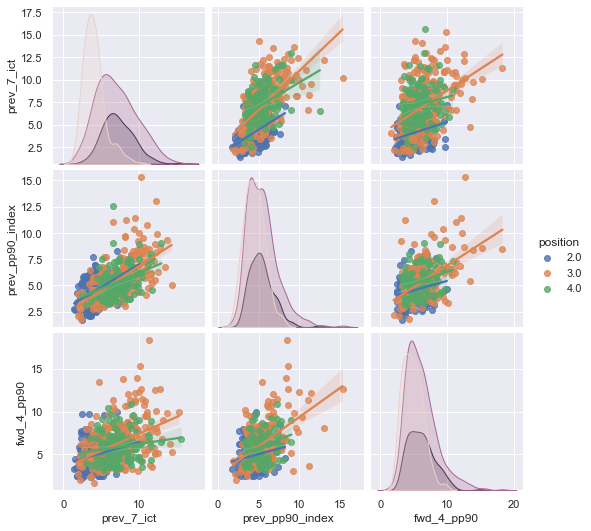

In [134]:
sns.pairplot(top_30_gw.loc[:, ['position',  'prev_7_ict', 'prev_pp90_index', 'fwd_4_pp90']], kind='reg', hue='position')

In [60]:
#recent history of midfielders is more reliable than recent history of forwards using the points per 90 index
#prev_7_ict looks like a fairly affective indicator for forwards

In [ ]:
#ict is not a predictor of future performance

In [137]:
team_df = df.loc[:, ['team', 'was_home', 'team_a_score', 'team_h_score', 'gw']]

In [149]:
team_df['g'] = team_df.loc[team_df['was_home'] == True, 'team_h_score']
team_df['g_away'] = team_df.loc[team_df['was_home'] == False, 'team_a_score']
team_df['ga'] = team_df.loc[team_df['was_home'] == True, 'team_a_score']
team_df['ga_away'] = team_df.loc[team_df['was_home'] == False, 'team_h_score']

In [153]:
team_df = team_df.fillna(value=0)
team_df['g'] = team_df['g'] + team_df['g_away']
team_df['ga'] = team_df['ga'] + team_df['ga_away']
team_df = team_df.drop(columns=['g_away', 'ga_away'])

In [179]:
team_df = team_df.sort_values(['team', 'gw']).drop_duplicates()

In [190]:
grouped_teams = team_df.groupby('team')[['g', 'ga']].mean().sort_values('ga').reset_index()

In [191]:
grouped_teams 

,team,g,ga
0,Man City,2.184211,0.842105
1,Chelsea,1.526316,0.947368
2,Arsenal,1.447368,1.026316
3,Liverpool,1.789474,1.105263
4,Spurs,1.789474,1.184211
5,Man Utd,1.972973,1.189189
6,Aston Villa,1.447368,1.210526
7,Brighton,1.052632,1.210526
8,West Ham,1.631579,1.236842
9,Everton,1.236842,1.263158


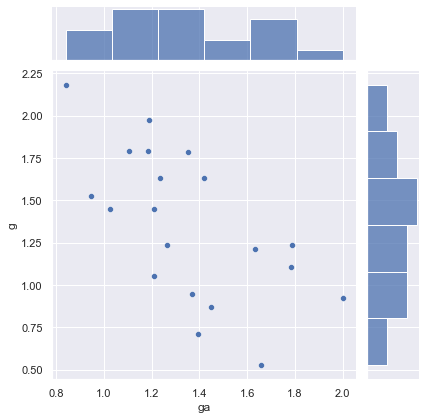

In [192]:
sns.jointplot(data=grouped_teams, x = 'ga', y = 'g')

In [193]:
df.head()

,name,position,team,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,round,team_a_score,team_h_score,total_points,value,was_home,gw,season,pp90,prev_5_pp90,prev_5_std,prev_5_max,prev_5_ict,fwd_5_pp90,fwd_4_pp90,prev_5_assists,prev_5_bps,prev_3_pp90,prev_3_std,prev_3_max,prev_3_ict,prev_3_assists,prev_3_bps,prev_7_pp90,prev_7_std,prev_7_max,prev_7_ict,prev_7_assists,prev_7_bps,prev_10_pp90,prev_10_std,prev_10_max,prev_10_ict,prev_10_assists,prev_10_bps,prev_pp90_index
66817,Aaron Connolly,4.0,Brighton,0,0,-3,0,0.3,78,7,2,0,3.4,1.2,2020-09-14T19:15:00Z,45,5,1,3.0,1.0,1,55,True,1,2020-21,2.000000,NaN,NaN,NaN,NaN,9.064974,3.831218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67242,Aaron Connolly,4.0,Brighton,0,2,27,1,11.3,78,16,0,1,6.9,34.8,2020-09-20T13:00:00Z,89,14,2,3.0,0.0,8,55,False,2,2020-21,8.089888,NaN,NaN,NaN,NaN,13.164974,4.057024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67781,Aaron Connolly,4.0,Brighton,0,0,2,0,12.1,78,19,2,0,1.9,0.0,2020-09-26T11:30:00Z,73,13,3,3.0,2.0,2,55,True,3,2020-21,2.465753,NaN,NaN,NaN,NaN,12.127642,2.748838,NaN,NaN,4.185214,3.389556,8.089888,4.066667,0.0,8.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68335,Aaron Connolly,4.0,Brighton,0,0,7,0,0.3,78,32,3,0,0.7,3.0,2020-10-03T14:00:00Z,65,7,4,2.0,4.0,2,55,False,4,2020-21,2.769231,NaN,NaN,NaN,NaN,12.205920,2.632400,NaN,NaN,4.441624,3.163131,8.089888,3.166667,0.0,12.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71872,Aaron Connolly,4.0,Brighton,0,0,0,0,12.0,78,90,1,0,4.0,0.0,2020-11-28T12:30:00Z,62,11,10,1.0,1.0,2,53,True,10,2020-21,2.903226,3.64562,2.508529,8.089888,3.38,4.194931,4.440092,0.0,6.6,2.712737,0.224141,2.903226,2.200000,0.0,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [201]:
team_ids = pd.read_csv('/Users/andrew.peters/Documents/GitHub/Fantasy-Premier-League/data/2020-21/teams.csv')

In [218]:
team_ids = team_ids.rename(columns={x: 'opp_' + x for x in team_ids.columns}) #renaming the columns because i'll merge this with the df for opponent data

In [220]:
list(team_ids)

['opp_code',
 'opp_draw',
 'opp_form',
 'opp_id',
 'opp_loss',
 'opp_name',
 'opp_played',
 'opp_points',
 'opp_position',
 'opp_short_name',
 'opp_strength',
 'opp_team_division',
 'opp_unavailable',
 'opp_win',
 'opp_strength_overall_home',
 'opp_strength_overall_away',
 'opp_strength_attack_home',
 'opp_strength_attack_away',
 'opp_strength_defence_home',
 'opp_strength_defence_away',
 'opp_pulse_id',
 'opp_opponent_team_name']

In [224]:
df = df.merge(team_ids[['opp_id', 
        'opp_name',
        'opp_strength',
        'opp_strength_overall_home',
        'opp_strength_overall_away',
        'opp_strength_attack_home',
        'opp_strength_attack_away',
        'opp_strength_defence_home',
        'opp_strength_defence_away']], 
        left_on='opponent_team', right_on='opp_id')

In [225]:
df.head()

,name,position,team,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,round,team_a_score,team_h_score,total_points,value,was_home,gw,season,pp90,prev_5_pp90,prev_5_std,prev_5_max,prev_5_ict,fwd_5_pp90,fwd_4_pp90,prev_5_assists,prev_5_bps,prev_3_pp90,prev_3_std,prev_3_max,prev_3_ict,prev_3_assists,prev_3_bps,prev_7_pp90,prev_7_std,prev_7_max,prev_7_ict,prev_7_assists,prev_7_bps,prev_10_pp90,prev_10_std,prev_10_max,prev_10_ict,prev_10_assists,prev_10_bps,prev_pp90_index,opp_id,opp_name,opp_strength,opp_strength_overall_home,opp_strength_overall_away,opp_strength_attack_home,opp_strength_attack_away,opp_strength_defence_home,opp_strength_defence_away
0,Aaron Connolly,4.0,Brighton,0,0,-3,0,0.3,78,7,2,0,3.4,1.2,2020-09-14T19:15:00Z,45,5,1,3.0,1.0,1,55,True,1,2020-21,2.0,NaN,NaN,NaN,NaN,9.064974,3.831218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,Chelsea,4,1250,1280,1260,1300,1250,1310
1,Aaron Cresswell,2.0,West Ham,0,0,14,0,20.6,435,131,3,0,3.9,10.0,2020-12-21T20:00:00Z,90,5,14,0.0,3.0,1,52,False,14,2020-21,1.0,2.20,1.643168,5.0,3.68,6.000000,5.500000,0.2,13.0,2.666667,2.081666,5.00,3.766667,0.333333,14.000000,3.428571,2.507133,7.0,4.600000,0.142857,17.428571,3.200000,2.299758,7.0,4.38,0.2,17.4,2.450952,5,Chelsea,4,1250,1280,1260,1300,1250,1310
2,Aaron Wan-Bissaka,2.0,Man Utd,0,0,28,1,4.2,313,55,0,0,2.1,17.0,2020-10-24T16:30:00Z,90,5,6,0.0,0.0,6,54,True,6,2020-21,6.0,NaN,NaN,NaN,NaN,3.800000,4.500000,NaN,NaN,4.333333,4.725816,8.00,5.700000,0.000000,22.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,Chelsea,4,1250,1280,1260,1300,1250,1310
3,Aaron Wan-Bissaka,2.0,Man Utd,0,0,25,1,13.6,313,249,0,0,2.8,12.0,2021-02-28T16:30:00Z,90,5,26,0.0,0.0,6,56,False,26,2020-21,6.0,6.20,6.260990,17.0,4.60,5.000000,5.750000,0.4,25.6,3.333333,2.309401,6.00,2.433333,0.000000,17.000000,5.714286,5.559205,17.0,5.142857,0.285714,25.142857,5.400000,4.695151,17.0,4.69,0.2,23.6,4.280476,5,Chelsea,4,1250,1280,1260,1300,1250,1310
4,Abdoulaye DoucourÃ©,3.0,Everton,0,0,3,1,2.3,512,111,0,0,1.8,15.4,2020-12-12T20:00:00Z,90,5,12,0.0,1.0,2,53,True,12,2020-21,2.0,3.25,3.250000,9.0,4.78,3.000000,3.250000,0.0,15.6,2.083333,0.144338,2.25,3.300000,0.000000,9.000000,2.689850,2.825731,9.0,4.428571,0.000000,14.000000,2.816661,2.442322,9.0,4.57,0.1,14.8,2.330977,5,Chelsea,4,1250,1280,1260,1300,1250,1310


In [229]:
df = df.merge(grouped_teams, left_on='opp_name', right_on='team', suffixes=['', '_opp'])

In [231]:
df = df.drop(columns='team_opp') #redundant column from last merge
df = df.rename(columns={'g': 'opp_avg_g', 'ga': 'opp_avg_ga'})

In [235]:
player_pp90 = df.groupby('name')['pp90'].mean().reset_index()

In [237]:
player_pp90 = player_pp90.rename(columns={'pp90': 'avg_pp90'})

In [239]:
df = df.merge(player_pp90)

In [248]:
df['pct_variance'] = (df['pp90'] - df['avg_pp90']) / df['avg_pp90']

In [251]:
df.corr()['pct_variance'].sort_values()

goals_conceded              -2.928134e-01
opp_avg_g                   -1.345620e-01
opp_strength_overall_home   -1.287844e-01
opp_strength_overall_away   -1.280135e-01
opp_strength_defence_away   -1.252994e-01
opp_strength                -1.226388e-01
opp_strength_defence_home   -1.223354e-01
opp_strength_attack_away    -1.059562e-01
opp_strength_attack_home    -1.048768e-01
team_h_score                -4.219845e-02
team_a_score                -3.869840e-02
value                       -7.750361e-03
fixture                     -6.804308e-03
gw                          -6.270862e-03
round                       -6.270862e-03
avg_pp90                    -9.897690e-18
element                     -6.803366e-19
position                     7.089492e-19
was_home                     4.452408e-03
opp_id                       2.260285e-02
opponent_team                2.260285e-02
prev_10_ict                  3.624578e-02
prev_10_assists              4.947958e-02
minutes                      5.596

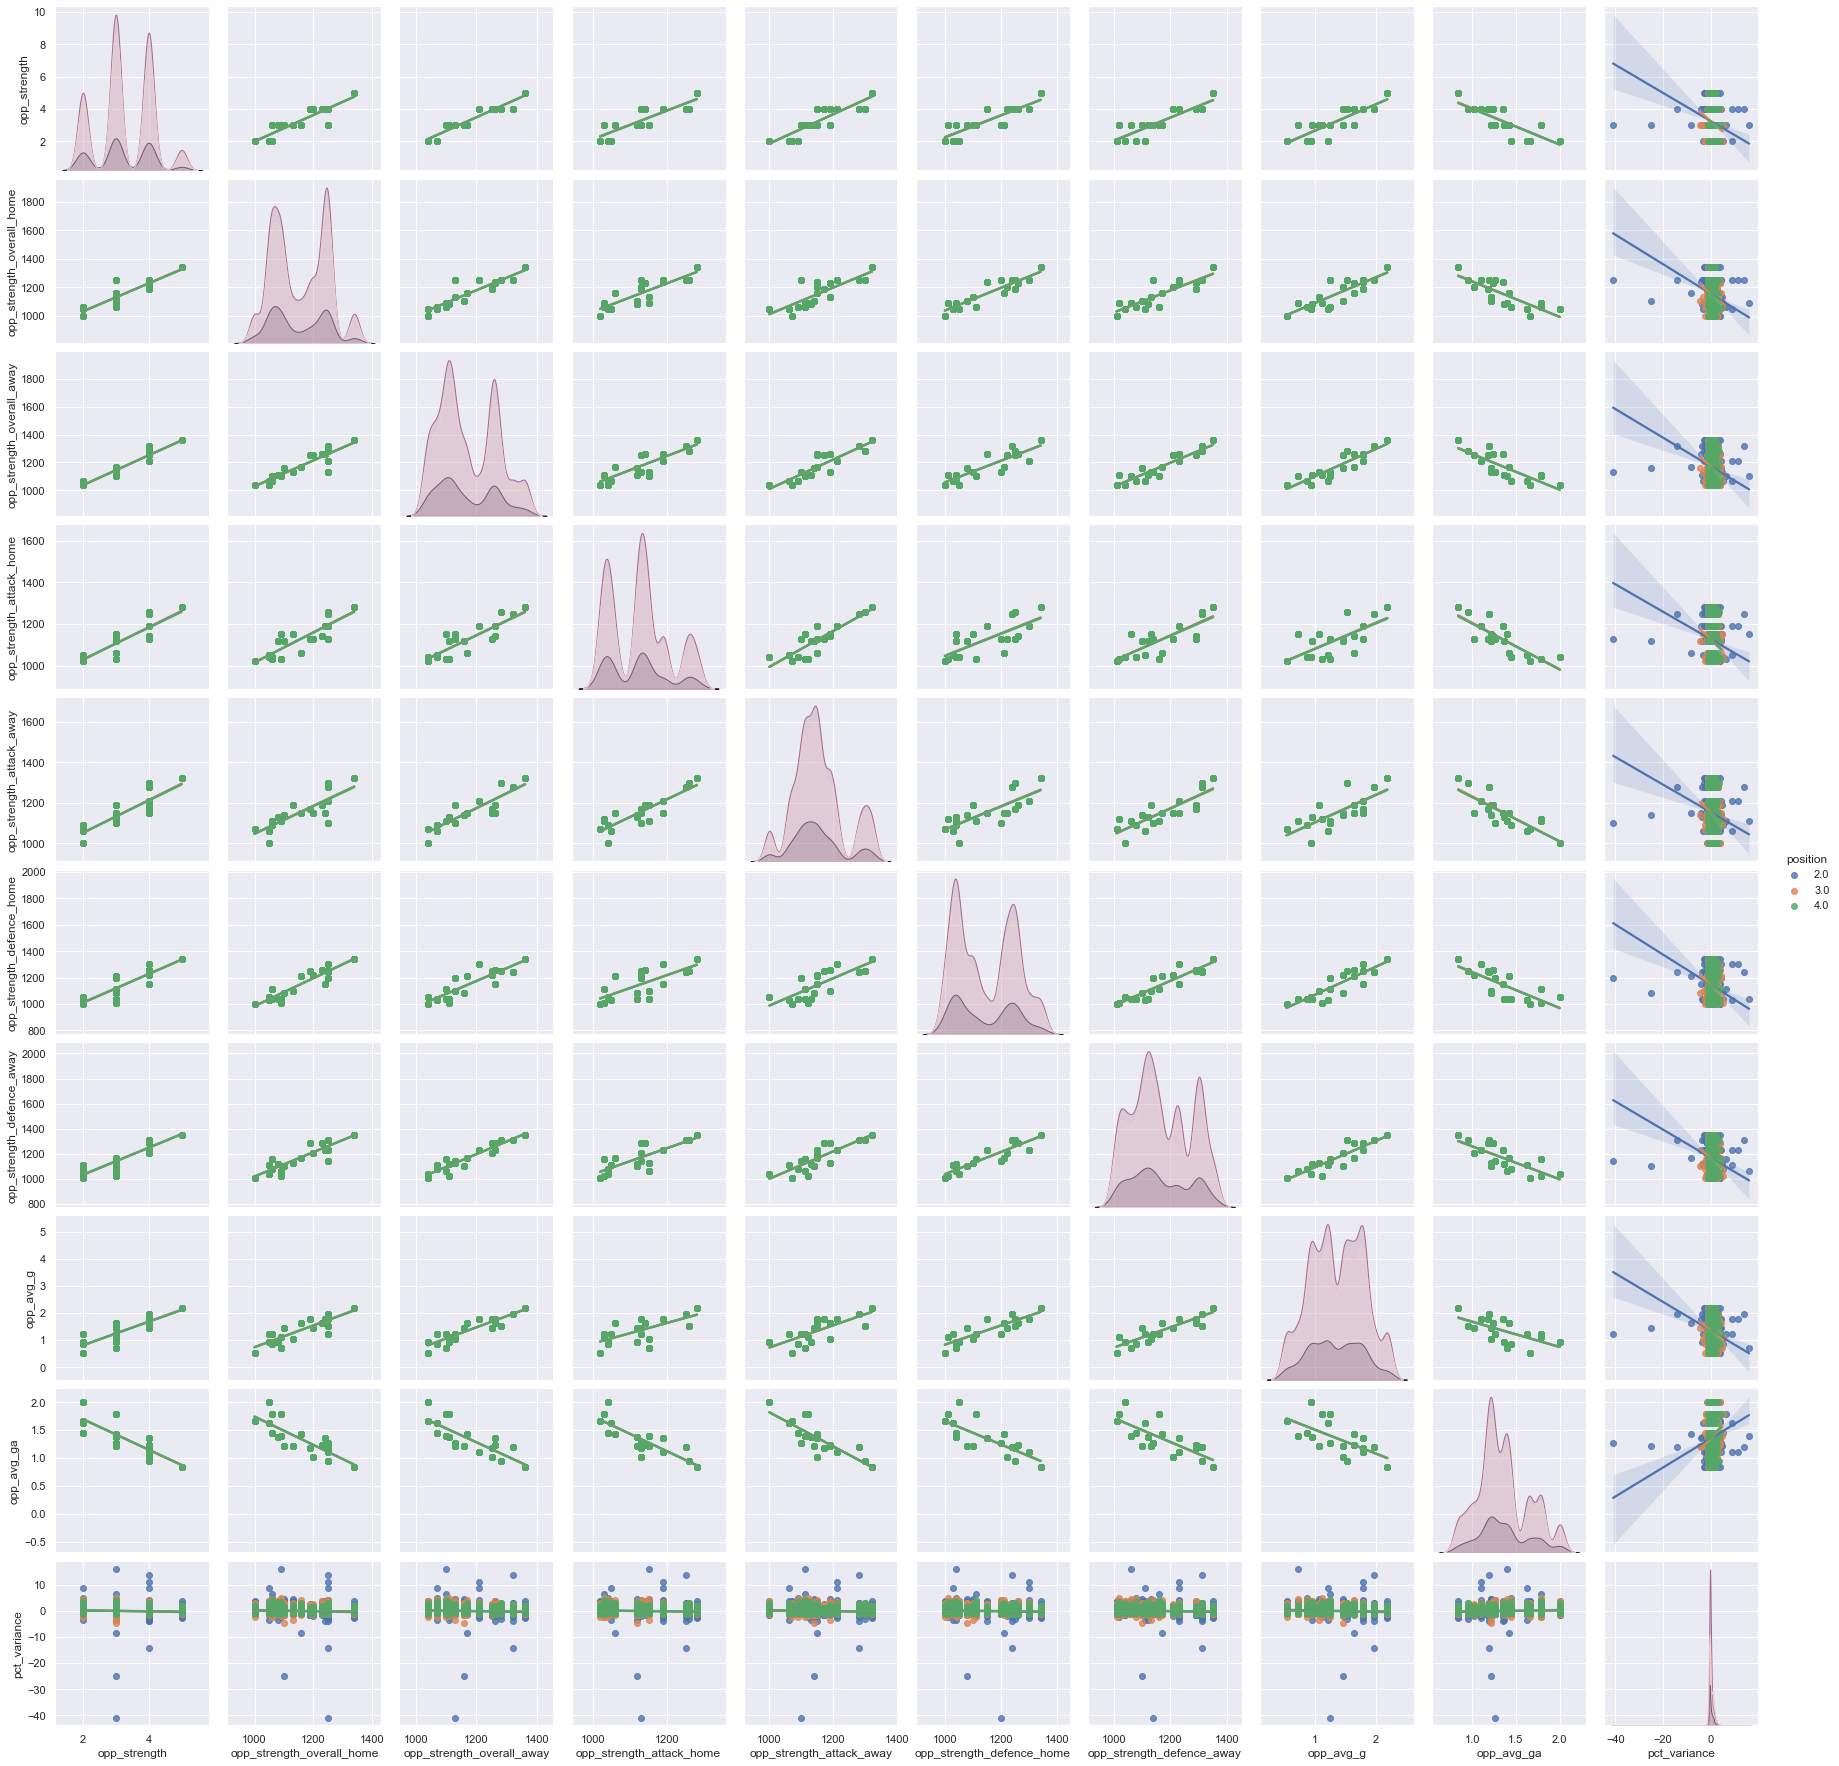

In [252]:
sns.pairplot(df.loc[:, ['position',
        'opp_strength',
        'opp_strength_overall_home',
        'opp_strength_overall_away',
        'opp_strength_attack_home',
        'opp_strength_attack_away',
        'opp_strength_defence_home',
        'opp_strength_defence_away',
        'opp_avg_g',
        'opp_avg_ga',
        'pct_variance']], kind='reg', hue='position')

In [253]:
X = df.opp_avg_ga
Y = df.pct_variance

X_mean = np.mean(X)
Y_mean = np.mean(Y)

num = 0
den = 0
for i in range(len(X)):
    num += (X[i] - X_mean)*(Y[i] - Y_mean)
    den += (X[i] - X_mean)**2
m = num / den
c = Y_mean - m*X_mean

print (m, c)

nan nan


In [258]:
opponent_strenth_data = df.loc[:, ['opp_strength',
                                'opp_strength_overall_home',
                                'opp_strength_overall_away',
                                'opp_strength_attack_home',
                                'opp_strength_attack_away',
                                'opp_strength_defence_home',
                                'opp_strength_defence_away',
                                'opp_avg_g',
                                'opp_avg_ga',
                                'pct_variance']]

In [261]:
opponent_strenth_data.dropna(inplace=True)

In [268]:
opp_ga_fit = np.polynomial.Polynomial.fit(opponent_strenth_data.opp_avg_ga, opponent_strenth_data.pct_variance, 1)
opp_g_fit = np.polynomial.Polynomial.fit(opponent_strenth_data.opp_avg_g, opponent_strenth_data.pct_variance, 1)

In [269]:
print(opp_ga_fit)
print(opp_g_fit)

poly([0.02797036 0.23878898])
poly([-0.00124032 -0.27442142])


In [279]:
opp_g_fit

Polynomial([-0.00124032, -0.27442142], domain=[0.52631579, 2.18421053], window=[-1.,  1.])

In [273]:
#I can use the above to make a calculation for how a player's pp90 changes based on the mean goals for or mean goals against of the opponent

Polynomial([0.02797036, 0.23878898], domain=[0.84210526, 2.        ], window=[-1.,  1.])

In [278]:
df.loc[:, ['avg_pp90', 'pp90', 'opp_avg_g']]

,avg_pp90,pp90,opp_avg_g
0,3.730551,2.000000,1.526316
1,3.730551,8.089888,1.210526
2,3.730551,2.465753,1.972973
3,3.730551,2.769231,1.236842
4,3.730551,2.903226,1.789474
...,...,...,...
7885,2.000000,2.000000,1.631579
7886,0.000000,0.000000,1.108108
7887,2.535211,2.535211,1.052632
7888,6.750000,6.750000,1.631579


In [293]:
starter_predictions = df.groupby(['name', 'element']).agg({'total_points': 'sum', 'pp90': 'mean'}).reset_index().sort_values('total_points', ascending=False)

In [294]:
starter_predictions.to_csv('starter_predictions.csv')

In [295]:
df[df.name == 'Bruno Miguel Borges Fernandes']

,name,position,team,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,round,team_a_score,team_h_score,total_points,value,was_home,gw,season,pp90,prev_5_pp90,prev_5_std,prev_5_max,prev_5_ict,fwd_5_pp90,fwd_4_pp90,prev_5_assists,prev_5_bps,prev_3_pp90,prev_3_std,prev_3_max,prev_3_ict,prev_3_assists,prev_3_bps,prev_7_pp90,prev_7_std,prev_7_max,prev_7_ict,prev_7_assists,prev_7_bps,prev_10_pp90,prev_10_std,prev_10_max,prev_10_ict,prev_10_assists,prev_10_bps,prev_pp90_index,opp_id,opp_name,opp_strength,opp_strength_overall_home,opp_strength_overall_away,opp_strength_attack_home,opp_strength_attack_away,opp_strength_defence_home,opp_strength_defence_away,opp_avg_g,opp_avg_ga,avg_pp90,pct_delta,pct_variance
809,Bruno Miguel Borges Fernandes,3.0,Man Utd,0,0,14,1,60.9,302,55,0,0,9.6,18.6,2020-10-24T16:30:00Z,90,5,6,0.0,0.0,3,105,True,6,2020-21,3.000000,8.000000,5.049752,12.000000,12.80,8.686486,8.358108,0.4,27.4,8.666667,4.932883,12.000000,13.033333,0.333333,28.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,Chelsea,4,1250,1280,1260,1300,1250,1310,1.526316,0.947368,7.271042,0.412596,-0.587404
810,Bruno Miguel Borges Fernandes,3.0,Man Utd,0,0,7,1,16.8,302,249,0,0,4.6,11.0,2021-02-28T16:30:00Z,90,5,26,0.0,0.0,3,116,False,26,2020-21,3.000000,9.600000,5.272571,17.000000,12.08,4.800000,4.750000,0.6,30.8,8.000000,4.582576,12.000000,9.066667,0.333333,23.666667,7.571429,5.533448,17.000000,10.557143,0.428571,25.285714,6.311364,5.002938,17.000000,9.84,0.4,21.3,7.366851,5,Chelsea,4,1250,1280,1260,1300,1250,1310,1.526316,0.947368,7.271042,0.412596,-0.587404
811,Bruno Miguel Borges Fernandes,3.0,Man Utd,1,3,49,0,78.7,302,45,1,1,22.0,85.4,2020-10-17T19:00:00Z,90,14,5,4.0,1.0,11,105,False,5,2020-21,11.000000,NaN,NaN,NaN,NaN,8.886486,8.358108,NaN,NaN,11.666667,0.577350,12.000000,13.833333,0.666667,36.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,Newcastle,2,1050,1070,1050,1060,1030,1110,1.210526,1.631579,7.271042,1.512851,0.512851
812,Bruno Miguel Borges Fernandes,3.0,Man Utd,1,3,41,0,43.6,302,245,1,1,13.3,60.8,2021-02-21T19:00:00Z,90,14,25,1.0,3.0,12,116,True,25,2020-21,12.000000,9.600000,5.272571,17.000000,11.98,6.200000,7.000000,0.6,31.0,9.333333,2.516611,12.000000,11.133333,0.333333,31.000000,7.857143,5.304984,17.000000,10.957143,0.571429,27.142857,7.057875,5.010880,17.000000,10.93,0.4,24.0,8.017692,14,Newcastle,2,1050,1070,1050,1060,1030,1110,1.210526,1.631579,7.271042,1.650382,0.650382
813,Bruno Miguel Borges Fernandes,3.0,Man Utd,1,3,51,0,21.2,302,73,1,2,17.3,93.6,2020-11-07T12:30:00Z,90,7,8,3.0,1.0,17,105,False,8,2020-21,17.000000,9.086486,6.246910,17.000000,11.98,10.600000,12.500000,0.4,28.4,7.477477,8.251628,17.000000,10.133333,0.333333,24.000000,8.490347,5.948595,17.000000,12.114286,0.428571,27.857143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,Everton,3,1250,1130,1130,1100,1200,1140,1.236842,1.263158,7.271042,2.338042,1.338042
814,Bruno Miguel Borges Fernandes,3.0,Man Utd,0,0,29,0,53.3,302,224,3,1,10.8,35.0,2021-02-06T20:00:00Z,90,7,23,3.0,3.0,7,115,True,23,2020-21,7.000000,6.800000,6.016644,17.000000,10.82,6.800000,7.750000,0.6,25.2,9.000000,7.211103,17.000000,12.433333,0.666667,30.333333,5.587662,5.339223,17.000000,10.171429,0.428571,20.285714,6.757875,4.971335,17.000000,11.49,0.5,23.1,6.813937,7,Everton,3,1250,1130,1130,1100,1200,1140,1.236842,1.263158,7.271042,0.962723,-0.037277
815,Bruno Miguel Borges Fernandes,3.0,Man Utd,0,0,3,1,24.5,302,184,0,0,7.9,7.4,2021-01-17T16:30:00Z,88,11,19,0.0,0.0,3,113,False,19,2020-21,3.068182,6.715751,4.404820,12.000000,12.16,6.013636,3.267045,0.4,21.0,5.192918,4.594404,10.465116,10.866667,0.000000,16.666667,8.244911,7.190185,21.857143,11.671429,0.428571,25.142857,8.271438,6.279381,21.857143,11.31,0.5,24.0,5.819985,11,Liverpool,4,1250,1210,1190,1210,1300,1230,1.789474,1.105263,7.271042,0.421973,-0.578027
816,Bruno Miguel Borges Fernandes,3.0,Man Utd,0,1,34,0,29.3,302,334,4,1,12.2,41.4,2021-05-13T19:1